In [ ]:
import numpy as np
import os
import pathlib
import skimage.io as io
import skimage.transform as tf
import skimage.exposure as ex
import skimage.color as color
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import random
import time
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def flip(images, labels, axis): 
    flipped_images = np.flip(images, axis)
    flipped_labels = labels
    return flipped_images,flipped_labels

def brightness(images, labels, gamma):
    brightness_images =  np.array([ex.adjust_gamma(image, gamma ,gain=1) for image in images])
    brightness_labels = labels
    return brightness_images, brightness_labels


def data_augmentation(images, labels):
    # Data augmentation (flip_horizontal)
    flipped_y_images,flipped_y_labels = flip(images, labels, axis=2)

    # Concatenate arrays
    images = np.concatenate([images, flipped_y_images])
    labels = np.concatenate([labels, flipped_y_labels])
    
    darken_images, darken_labels = brightness(images, labels, gamma=1.5)
    brighten_images, brighten_labels = brightness(images, labels, gamma=0.5)

    # Concatenate arrays
    images = np.concatenate([images, darken_images, brighten_images])
    labels = np.concatenate([labels, darken_labels, brighten_labels])
    
    return images, labels

In [ ]:
def load_data():
    path = pathlib.Path.cwd().parent / "content/drive/MyDrive/brain_tum" /"data" 
    images = []
    labels = []


    for directory in os.listdir(path):
        data_path = path / directory
        for subdirectory in os.listdir(data_path):
            subdata_path = data_path / subdirectory
            for im in os.listdir(subdata_path):
                image = io.imread(f"{subdata_path}/{im}")
                image = color.rgb2gray(image)
                image = tf.resize(image, (64, 64))
                images.append(image)  
                labels.append(subdirectory)

    images = np.array(images)
    labels = np.array(labels)

    images, labels = data_augmentation(images, labels)
    return images, labels


In [ ]:
from sklearn.model_selection import train_test_split

class Data():
    def __init__(self, loader, classes):
        super(Data, self).__init__()
        self.images, self.labels = loader
        self.classes = classes
        self.shapes = (self.images.shape, self.labels.shape)
        print("Data loaded successfully :)")

    def stat(self):
        keys = self.classes.keys()
        stat = {}
        for key in keys:
            n = 0
            for label in self.labels:
                if label == key:
                    n += 1
                else:
                    pass
            stat[key] = n
        plt.figure(figsize=(4, 4))
        plt.pie(stat.values(), labels=stat.keys(), autopct='%1.1f%%', explode=[0.1,0.1,0.1,0.1], shadow=True, startangle=90)
        plt.show()

    def shape(self):
        print(f"Images shape: {self.shapes[0]}",
              f"Labels shape: {self.shapes[1]}\n")

    def encode(self):
        total = len(self.classes)
        self.labels = np.array([self.classes[item] for item in self.labels])
        self.labels = np.eye(total)[self.labels]

    def decode(self, item):
        keys = list(self.classes.keys())
        index = np.argmax(item)
        label = keys[index]
        return label

    def show(self):
        f, axis = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
        for i, ax in enumerate(axis.flat):
            rand = random.randint(0, self.shapes[0][0] - 1)
            if len(self.shapes[0]) == 4:
                ax.imshow(self.images[rand])
            elif len(self.shapes[0]) == 3:
                ax.imshow(self.images[rand], cmap="gray")

            title = f"target: {self.labels[rand]}"
            ax.set_title(title)
        plt.show()

    def dataset(self, split_size, shuffle, random_state, images_format,
                labels_format, permute, one_hot, device):

        if len(self.shapes[0])==3:
            self.images = np.expand_dims(self.images, axis=3)

        elif len(self.shapes[0])==4:
            pass

        if one_hot:
            self.encode()
        else:
            pass

        x_train, x_val, y_train, y_val = train_test_split(self.images,
                                                          self.labels,
                                                          test_size=split_size,
                                                          shuffle=shuffle,
                                                          random_state=random_state)

        x_test, x_val, y_test, y_val = train_test_split(x_val, y_val,
                                                        test_size=0.4,
                                                        shuffle=shuffle,
                                                        random_state=random_state)

        # Free memory
        del self.images, self.labels

        # Convert Numpy arrays to Torch tensors
        self.train_inputs = torch.from_numpy(x_train).to(images_format).to(device)
        self.train_outputs = torch.from_numpy(y_train).to(labels_format).to(device)
        del x_train, y_train

        self.val_inputs = torch.from_numpy(x_val).to(images_format).to(device)
        self.val_outputs = torch.from_numpy(y_val).to(labels_format).to(device)
        del x_val, y_val

        self.test_inputs = torch.from_numpy(x_test).to(images_format).to(device)
        self.test_outputs = torch.from_numpy(y_test).to(labels_format).to(device)
        del x_test, y_test

        if permute:
            self.train_inputs = self.train_inputs.permute(0, 3, 1, 2)
            self.val_inputs = self.val_inputs.permute(0, 3, 1, 2)
            self.test_inputs = self.test_inputs.permute(0, 3, 1, 2)

        # Verify datasets shapes
        print(f"Train tensor shape: {self.train_inputs.shape}, {self.train_outputs.shape}")
        print(f"Test tensor shape: {self.test_inputs.shape}, {self.test_outputs.shape}")
        print(f"Validation tensor shape: {self.val_inputs.shape}, {self.val_outputs.shape}")

        print("\nDataset generated successfully :)")

Data loaded successfully :)
Images shape: (19584, 64, 64) Labels shape: (19584,)



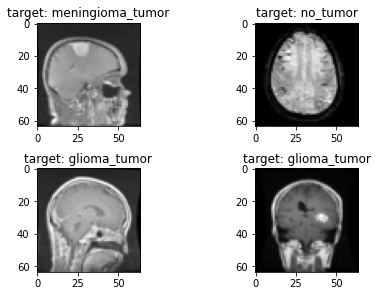

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

data = Data(loader=load_data(), classes=classes)
data.shape()
data.show()

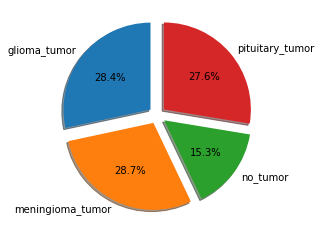

In [ ]:
data.stat()

In [ ]:
# divided dataset into train,test,validate(used to improve parameters )
data.dataset(split_size=0.08, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True,one_hot=True ,device=device)

Train tensor shape: torch.Size([18017, 1, 64, 64]), torch.Size([18017, 4])
Test tensor shape: torch.Size([940, 1, 64, 64]), torch.Size([940, 4])
Validation tensor shape: torch.Size([627, 1, 64, 64]), torch.Size([627, 4])

Dataset generated successfully :)


In [ ]:
# Define CNN 
class conv_layer(torch.nn.Module):

    def __init__(self, in_features, out_features):
        super(conv_layer, self).__init__()
        self.conv = torch.nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.norm = torch.nn.BatchNorm2d(out_features)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.relu(X)
        X = self.norm(X)
        X = self.pool(X)
        return X


class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(1, affine=False)
        self.layer1 = conv_layer(in_features=1, out_features=8)
        self.layer2 = conv_layer(in_features=8, out_features=16)
        self.layer3 = conv_layer(in_features=16, out_features=32)
        self.layer4 = conv_layer(in_features=32, out_features=64)
        self.layer5 = conv_layer(in_features=64, out_features=128)
        self.layer6 = conv_layer(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=4)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [ ]:
def rmse(target, pred):
    MSE = torch.nn.functional.mse_loss(target, pred, reduction="sum")
    return torch.sqrt(MSE)

In [ ]:
class Model():
    def __init__(self, network, optimizer, device):
        super(Model, self).__init__()
        self.net = network.to(device)
        self.optim = optimizer
        self.device = device
        print("Model initialized succssefully :)\n")

    def train(self, train_data, val_data, epochs, patience, batch_size, learning_rate):
        if self.optim == "adam":
            self.optim = torch.optim.Adam(self.net.parameters(), lr=learning_rate)
        best_loss = np.inf
        self.patience = patience
        self.train_losses = []
        self.val_losses = []
        self.achieved_epochs = []
        train_inputs, train_outputs = train_data
        val_inputs, val_outputs = val_data
        total_train = train_inputs.size()[0]
        total_val = val_inputs.size()[0]
        print("Train loop:\n")

        t0 = time.time()
        for epoch in range(epochs):
            self.net.train()
            train_loss = 0
            val_loss = 0
            self.achieved_epochs.append(epoch)
            train_permutation = torch.randperm(total_train)
            val_permutation = torch.randperm(total_val)

            for i in range(0, total_train, batch_size):
                self.optim.zero_grad()
                indices = train_permutation[i:i+batch_size]
                batch_x, batch_y = train_inputs[indices], train_outputs[indices]
                outputs = self.net(batch_x)
                loss = rmse(outputs, batch_y)
                loss.backward()
                self.optim.step()
                train_loss += loss
            train_loss = train_loss.cpu().detach() / total_train
            self.train_losses.append(train_loss)

            for j in range(0, total_val, batch_size):
                self.net.eval()
                indices = val_permutation[j:j+batch_size]
                batch_x, batch_y = val_inputs[indices], val_outputs[indices]
                outputs = self.net(batch_x)
                loss = rmse(outputs, batch_y)
                val_loss += loss
            val_loss = val_loss.cpu().detach() / total_val
            self.val_losses.append(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                cost_patience = patience
                self.state_dict = copy.deepcopy(self.net.state_dict())
                print(f"\tEpoch: {epoch+1}/{epochs}, ",
                      f"Train Loss: {train_loss:.3g}, ",
                      f"Val Loss: {val_loss:.3g}")

            else:
                cost_patience -= 1
                if cost_patience < 0:
                    print(f"\nEarly stopping after {patience} epochs of no improvements")
                    break

                else:
                    print(f"\tEpoch: {epoch+1}/{epochs}, ",
                          f"Train Loss: {train_loss:.3g}, ",
                          f"Val Loss: {val_loss:.3g} - No improvement",
                          f"-> Remaining patience: {cost_patience}")

        tf = time.time()
        print(f"\nTrain finished successfully in {tf-t0:.3g}s")

    def evaluate(self, test_data):
        test_inputs, test_outputs = test_data
        self.net.load_state_dict(self.state_dict)
        predictions = self.net(test_inputs).cpu().detach().numpy()
        correct = 0
        wrong = 0
        li = []
        for i,(j,k) in enumerate(zip(predictions, test_outputs.cpu().detach())):
            li1=[np.argmax(j),np.argmax(k)]
            li.append(li1)
            if np.argmax(j) == np.argmax(k):
                correct +=1
            else:
                wrong += 1

        score = 100 * correct / test_outputs.shape[0]
        print(f'\nTest accuracy:{score:.3g}%')
        print(f'Correct predictions: {correct}, Wrong predictions: {wrong}')
        return li

    def save(self, path, checkpoint_name):
        torch.save(self.state_dict, f"{path}/{checkpoint_name}.pth")
        print("\nCheckpoint saved successfully :)")

    def plot_loss(self):
        f, ax = plt.subplots()
        ax.plot(self.achieved_epochs, self.train_losses, label='train')
        ax.plot(self.achieved_epochs, self.val_losses, label='validation')
        ax.set_title('model loss')
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')
        no_improvement_line = self.achieved_epochs[-1] - self.patience
        ax.axvline(x=no_improvement_line, color='r')
        ax.legend(loc='upper center', frameon=False)
        plt.show()
      
    def predict(self,image):
      img = np.expand_dims(image, axis=0)
      img = torch.Tensor(img).permute( 3, 1, 2).to(device)
      print(img.shape)
      pred = self(img)
      pred_np = pred.cpu().detach().numpy()
      print(np.argmax(pred_np))


In [ ]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=1.0E-3)

BrainTumorClassifier = Model(net, optimizer, device)
BrainTumorClassifier.train(train_data=(data.train_inputs, data.train_outputs),
                           val_data=(data.val_inputs, data.val_outputs),
                           epochs=20, patience=5, batch_size=100,learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/20,  Train Loss: 0.0711,  Val Loss: 0.0629
	Epoch: 2/20,  Train Loss: 0.0443,  Val Loss: 0.0437
	Epoch: 3/20,  Train Loss: 0.0327,  Val Loss: 0.0338
	Epoch: 4/20,  Train Loss: 0.0257,  Val Loss: 0.0244
	Epoch: 5/20,  Train Loss: 0.0214,  Val Loss: 0.0218
	Epoch: 6/20,  Train Loss: 0.0184,  Val Loss: 0.0221 - No improvement -> Remaining patience: 4
	Epoch: 7/20,  Train Loss: 0.0165,  Val Loss: 0.0158
	Epoch: 8/20,  Train Loss: 0.0148,  Val Loss: 0.0176 - No improvement -> Remaining patience: 4
	Epoch: 9/20,  Train Loss: 0.0146,  Val Loss: 0.0238 - No improvement -> Remaining patience: 3
	Epoch: 10/20,  Train Loss: 0.0142,  Val Loss: 0.0186 - No improvement -> Remaining patience: 2
	Epoch: 11/20,  Train Loss: 0.0126,  Val Loss: 0.0143
	Epoch: 12/20,  Train Loss: 0.0123,  Val Loss: 0.0184 - No improvement -> Remaining patience: 4
	Epoch: 13/20,  Train Loss: 0.0124,  Val Loss: 0.0141
	Epoch: 14/20,  Train Loss: 0.0117,  Val Loss: 0.

In [ ]:
pre = BrainTumorClassifier.evaluate(test_data=(data.test_inputs, data.test_outputs))


Test accuracy:99.6%
Correct predictions: 936, Wrong predictions: 4


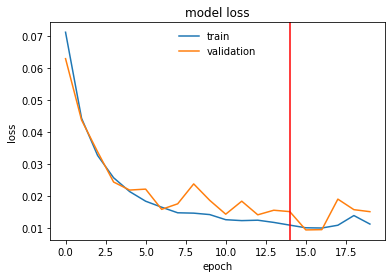


Checkpoint saved successfully :)


In [ ]:
BrainTumorClassifier.plot_loss()
BrainTumorClassifier.save(path="./", checkpoint_name="module")